In [2]:
import pandas as pd
from scipy import stats
from scipy.stats import ksone
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import re
from joblib import dump, load
import joblib  
import functions_framework


In [3]:
df = pd.read_csv('diamonds.csv')
df_coords = pd.read_csv('coords_diamonds.csv')
df = df.drop('Unnamed: 0', axis=1)

In [7]:
df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

## Data visualization

carat


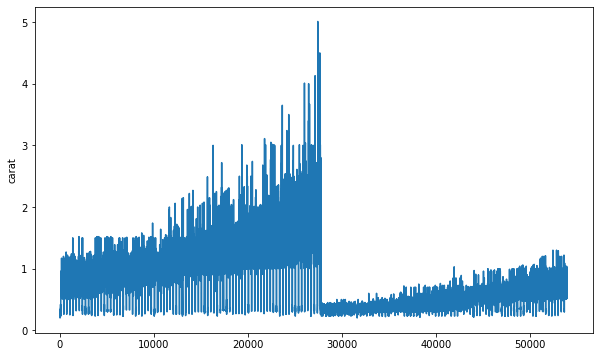

cut


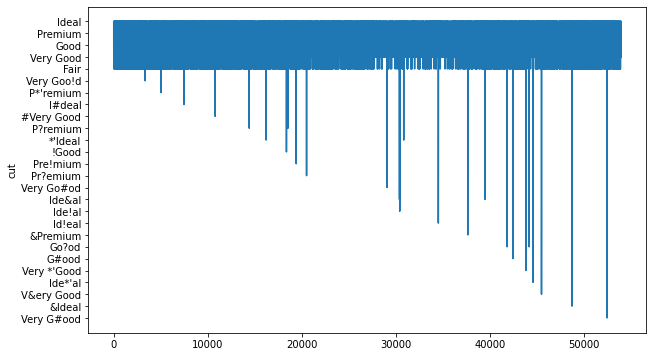

color


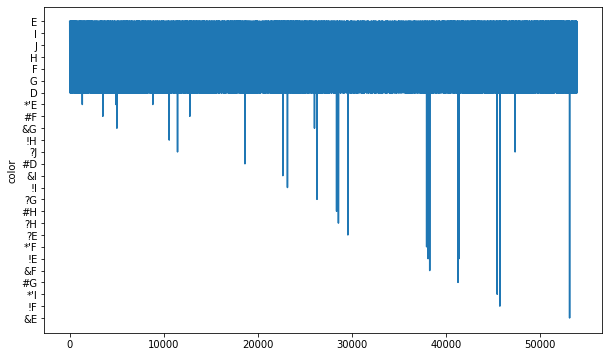

clarity


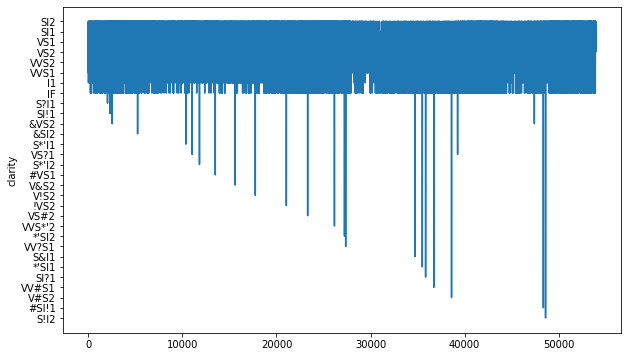

depth


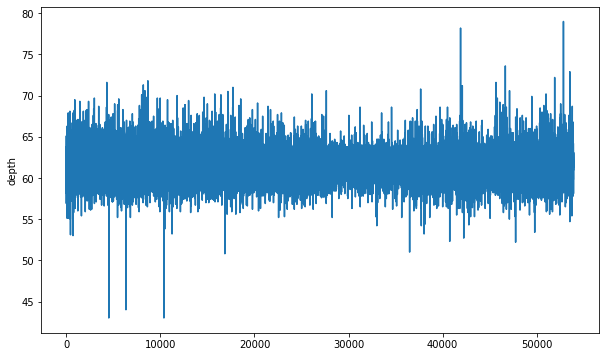

table


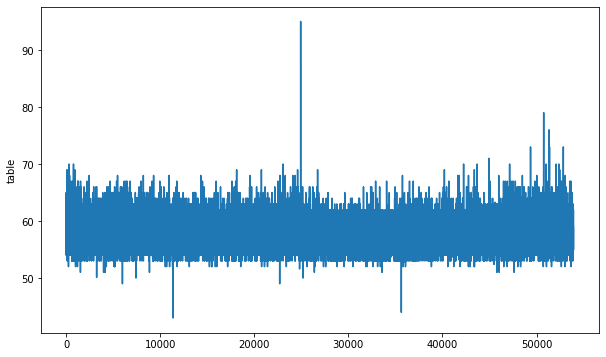

price


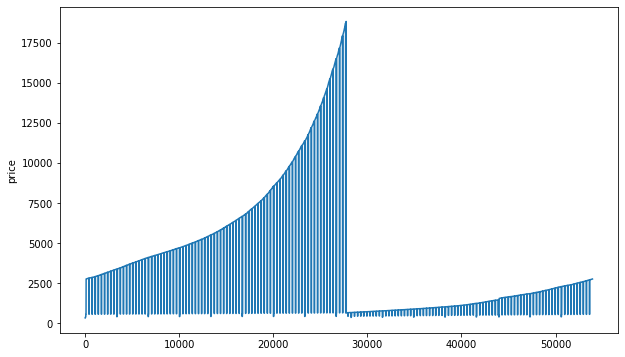

x


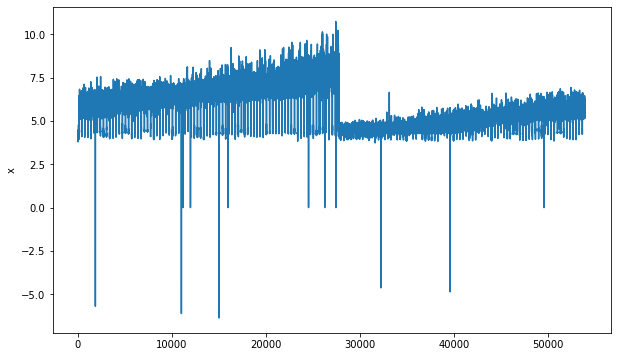

y


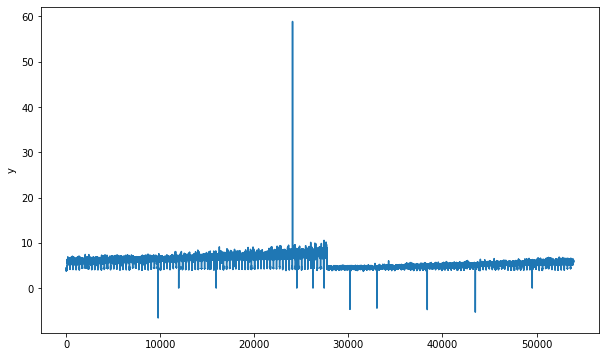

z


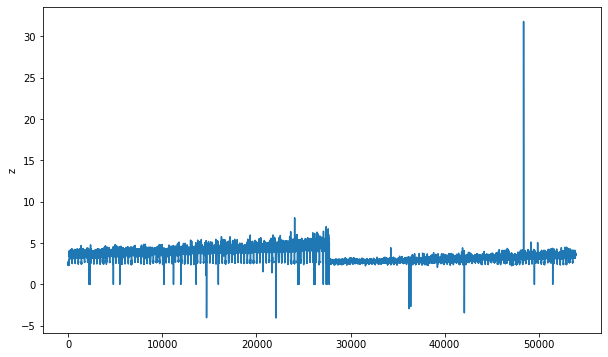

In [3]:
for x in df.columns:
    print(x)
    #Configure the graph
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df[x], palette='BuPu') 



    # Show the graph
    plt.show()

## Homologation

CUT

In [4]:
# Function to clean the values
def clean_value(value):
    # Remove special characters
    clean_value = re.sub(r"[^a-zA-Z\s]", '', value)
    # Correct common errors and standardize
    corrections = {
        'Very Goo': 'Very Good',
        'Very Go': 'Very Good',
        'V&ery Good': 'Very Good',
        'Very G#ood': 'Very Good',
        "Very *'Good": 'Very Good',
        'Very Go#od': 'Very Good',
        'Ide&al': 'Ideal',
        'Ide!al': 'Ideal',
        'Id!eal': 'Ideal',
        "Ide*'al": 'Ideal',
        '*Ideal': 'Ideal',
        'I#deal': 'Ideal',
        '&Ideal': 'Ideal',
        'Pre!mium': 'Premium',
        'Pr?emium': 'Premium',
        "P*'remium": 'Premium',
        'P?remium': 'Premium',
        '&Premium': 'Premium',
        'Go?od': 'Good',
        'G#ood': 'Good',
        '!Good': 'Good'
    }
    return corrections.get(clean_value, clean_value)

# Clean and standardize the values in the column
df['cut'] = df['cut'].apply(clean_value)

COLOR

In [5]:
df['color'] = df['color'].replace(to_replace=r"[^EIJHFGD]", value='', regex=True)

CLARITY

In [6]:
mapeo = {
    'SI2': 'SI2', 'SI1': 'SI1', 'VS1': 'VS1', 'VS2': 'VS2', 'VVS2': 'VVS2', 'VVS1': 'VVS1',
    'I1': 'I1', 'IF': 'IF',
    'S?I1': 'SI1', 'SI!1': 'SI1', '&VS2': 'VS2', '&SI2': 'SI2', "S*'I1": 'SI1',
    'VS?1': 'VS1', "S*'I2": 'SI2', '#VS1': 'VS1', 'V&S2': 'VS2', 'V!S2': 'VS2',
    '!VS2': 'VS2', 'VS#2': 'VS2', "VVS*'2": 'VVS2', "*'SI2": 'SI2', 'VV?S1': 'VVS1',
    'S&I1': 'SI1', "*'SI1": 'SI1', 'SI?1': 'SI1', 'VV#S1': 'VVS1', 'V#S2': 'VS2',
    '#SI!1': 'SI1', 'S!I2': 'SI2'
}



# Apply replace function with regex=True to enable regular expressions
df['clarity'] = df['clarity'].replace(mapeo, regex=False)


## Validación

Numeric columns

In [7]:
# Get the names of columns with integer or floating point data types
num_columns = df.select_dtypes(include=['int64', 'float64']).columns

def validate_num_columns(df, num_columns):
    for column in num_columns:
        data_type = df[column].dtypes

        # Check if the data type is numeric
        if data_type == 'int' or data_type == 'float':
            print("The column is completely numeric")
        else:
            print(f"The column {column} contains non-numeric data")

validate_num_columns(df, num_columns)

The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is completely numeric


Text columns

In [8]:
# Get column names with data type 'object'
num_columns = df.select_dtypes(include=['object']).columns

def categorical_column(df, num_columns):
    for column in num_columns:
        data_type = df[column].dtypes

        # Check if the data type is numeric
        if data_type == 'object':
            print("The column is entirely text")
        else:
            print(f"The column {column} contains non-text data")

categorical_column(df, num_columns)


The column is entirely text
The column is entirely text
The column is entirely text


## Missings values

We create our training and validation sets

In [9]:
X_train,X_test=train_test_split(df,test_size=.2,random_state=413)

In [10]:
def missing_values(df, num_columns):
    for column in num_columns:
        # Calculate mean, median, and mode after dropping NA values
        mean = df[column].dropna().mean()
        median = df[column].dropna().median()
        mode = df[column].dropna().mode()[0]  # mode() returns a Series, take the first value

        print(f"\n{column}: The mean is {mean}, the median is {median}, and the mode is {mode}")
        
        # Compare original non-NA values with values imputed by mean, median, or mode
        for metric in [mean, median, mode]:
            original = list(df[column].dropna().values)
            imputed = list(df[column].fillna(metric).values)
            
            # Perform the Kolmogorov-Smirnov test
            ks_stat, ks_pvalue = stats.ks_2samp(original, imputed)
            
            # Print or store the results
            print(f"KS test for {metric}: statistic={ks_stat}, p-value={ks_pvalue}")

In [11]:
num_columns = df.columns[df.isna().any()].tolist()
missing_values(X_train,num_columns)


depth: The mean is 61.7516227951819, the median is 61.8, and the mode is 62.0
KS test for 61.7516227951819: statistic=0.029593963871762496, p-value=2.2130365911915135e-16
KS test for 61.8: statistic=0.02748194668708115, p-value=3.4751680220647744e-14
KS test for 62.0: statistic=0.029883689306071326, p-value=1.0741422552910769e-16

x: The mean is 5.728688699108136, the median is 5.69, and the mode is 4.37
KS test for 5.728688699108136: statistic=0.01039515926092327, p-value=0.01967489540692731
KS test for 5.69: statistic=0.010113691511548506, p-value=0.025180008502440954
KS test for 4.37: statistic=0.01789234955124283, p-value=2.2814308079606564e-06

y: The mean is 5.731230639454507, the median is 5.71, and the mode is 4.33
KS test for 5.731230639454507: statistic=0.005548181400352514, p-value=0.5218516493109235
KS test for 5.71: statistic=0.005405387063054268, p-value=0.555752257300214
KS test for 4.33: statistic=0.009979117586142616, p-value=0.02769077043159418


Best value to impute:
- For "depth", the median is recommended.
- For "x", the median is recommended, although the difference with the mean is minimal.
- For "y", the median is recommended, given its closest resemblance to the original distribution.

In [12]:
def complete_missing_values(imp,num_columns):
    for column in num_columns:
        X_train[column]=imp.fit_transform(X_train[[column]])
        X_test[column]=imp.transform(X_test[[column]])

imp=SimpleImputer(missing_values=np.nan,strategy="median")
complete_missing_values(imp,num_columns)

## Outliers

We unify the clean df

In [13]:
df = pd.concat([X_train, X_test], axis=0)

- n_estimators: number of trees that make up the model.

- max_samples: number of observations used to train each tree.

- max_features : The number of features to be extracted to train each base estimator.

- contamination: proportion of expected anomalies in the training data. Based on this value, the limit is established according to which the observations are classified as normal or anomalous.

- random_state: seed to ensure reproducibility of results.

A model is trained assuming that there are 1% anomalous observations in the training set.

In [14]:
df_iso = df.select_dtypes(include=['int64', 'float64'])
max_features=df_iso.shape[1]
n_estimators=50
max_samples='auto'
contamination=float(0.06)
model=IsolationForest(max_features = max_features, n_estimators=n_estimators, max_samples=max_samples, contamination=contamination)
model.fit(df_iso)
df_iso["outlier"]=model.predict(df_iso)
df = pd.concat([df_iso, df[['cut', 'color', 'clarity']]], axis=1)
df = df[df["outlier"]!=-1].reset_index(drop=True)
df = df.drop('outlier', axis=1)

/home/andrea/Escritorio/envs/diplomado/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


/home/andrea/Escritorio/envs/diplomado/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/tmp/ipykernel_10465/779421519.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iso["outlier"]=model.predict(df_iso)


In [15]:
df_iso.outlier.value_counts()

 1    50694
-1     3236
Name: outlier, dtype: int64

## Data Engineering

In [18]:
num_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df,columns = num_columns, prefix_sep='_') 

## Correlation

In [19]:
def correlation(df):
    corr=df.corr(method="spearman")
    corr=abs(corr)
    corr=corr[['price']].sort_values(by = 'price' , ascending = False)
    list_corr = list(corr[corr['price']>.01].index)
    df = df[list_corr]
    return df, list_corr

df, list_corr = correlation(df)


## Normalization

In [20]:
price_scaler = MinMaxScaler()
price_scaler.fit(df[['price']])
joblib.dump(price_scaler, 'price_scaler.joblib')

['price_scaler.joblib']

In [21]:
def normalize(df):
    X_train,X_test=train_test_split(df,test_size=.2,random_state=413)
    scaler = MinMaxScaler()
    scaler.fit(X_train)

    index_train = X_train.index
    index_test = X_test.index

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=index_test)
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=index_train)
    df = pd.concat([X_train, X_test], axis=0)
    return df

df = normalize(df)

## Models

### Linear regression

In [22]:
# Define the characteristics and the target variable
X = df.drop('price', axis=1)
y = df['price']

In [23]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


# Predict on training set and test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)



# Evaluate the model for the training and test set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

In [39]:
print(f"Train : MSE = {mse_train:.6f}, R^2 = {r2_train:.2f}")
print(f"Test: MSE = {mse_test:.6f}, R^2 = {r2_test:.2f}")

Train : MSE = 0.002812, R^2 = 0.91
Test: MSE = 0.002718, R^2 = 0.91


The model is not significantly overfitted, as there is not a large difference between the MSE of the training set and the test set, suggesting that the model has consistent performance on both sets.

 The results of the Score are indicative of a good fit and a good generalization capacity of the model. Which means that the model can explain 90% of the variability in diamond prices, which are excellent results

### SVM

In [35]:
# Import the necessary libraries
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


# Initialize and train the SVR model
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# Predict on training set and test set
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

# Evaluate the model for the training set

mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


# Evaluate the model for the test set

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f"Rendimiento en el conjunto de entrenamiento: MSE = {mse_train:.6f}, R^2 = {r2_train:.2f}")
print(f"Rendimiento en el conjunto de prueba: MSE: MSE = {mse_test:.6f}, R^2 = {r2_test:.2f}")


Rendimiento en el conjunto de entrenamiento: MSE = 0.002129, R^2 = 0.93
Rendimiento en el conjunto de prueba: MSE = 0.002139, R^2 = 0.93


Both the linear regression model and the Support Vector Machines (SVM) model have been shown to fit our data quite well.
We can conclude that we are well positioned to provide reliable and accurate diamond price estimates

# How much are stolen diamonds worth?

We save the final version of the model that we will use for our predictions

In [25]:
stolendiamonds = pd.read_csv('StolenDiamonds.csv')

In [26]:
# from joblib import dump, load

# # Guardar el modelo a un archivo
# dump(model, 'model_regresion_lineal.joblib')

In [27]:
def preprocessing(df, list_corr, num_columns_numeric, num_columns_categoric):
    df['cut'] = df['cut'].apply(clean_value)
    df['color'] = df['color'].replace(to_replace=r"[^EIJHFGD]", value='', regex=True)
    df['clarity'] = df['clarity'].replace(mapeo, regex=False)
    validate_num_columns(df, num_columns_numeric)
    categorical_column(df, num_columns_categoric)
    df = pd.get_dummies(df, columns=num_columns_categoric, prefix_sep='_')  
    
    for column in list_corr:
        if column not in df.columns:
            df[column] = 0  # Create the column and assign the value '0'
    
    df = df[list_corr]  # Makes sure that df only contains the columns in list_corr
    df = normalize(df)
    return df

In [28]:
num_columns_numeric = stolendiamonds.select_dtypes(include=['int64', 'float64']).columns
num_columns_categoric = stolendiamonds.select_dtypes(include=['object']).columns
list_corr = ['carat', 'y', 'z', 'x', 'table', 'clarity_SI2', 'clarity_VVS1',
 'cut_Ideal', 'cut_Premium', 'color_E', 'clarity_IF', 'clarity_VVS2', 'color_J',
 'color_D', 'cut_Fair', 'color_H', 'clarity_SI1', 'color_I', 'depth',
 'cut_Good', 'clarity_I1', 'cut_Very Good', 'clarity_VS1', 'color_G']
df_preprocessed = preprocessing(stolendiamonds, list_corr, num_columns_numeric, num_columns_categoric)

The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is completely numeric
The column is entirely text
The column is entirely text
The column is entirely text


In [29]:
model_loaded = load('model_regresion_lineal.joblib')
precio_scaler_loaded = joblib.load('price_scaler.joblib')

# Making predictions with the model
y_pred = model_loaded.predict(df_preprocessed)

# Performing the inverse transformation of the 'price' predictions
y_pred_inverse = precio_scaler_loaded.inverse_transform(y_pred.reshape(-1, 1))


/home/andrea/Escritorio/envs/diplomado/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/andrea/Escritorio/envs/diplomado/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


## Price of stolen diamonds

In [30]:
y_pred_inverse

array([[11445.1875568 ],
       [ 4683.1353222 ],
       [13075.1436975 ],
       [  945.13543956],
       [ 4115.30984135],
       [ 9862.54977139],
       [10207.35885603],
       [ 3356.06023106],
       [15248.3998464 ],
       [10826.77409248]])

In [31]:
stolendiamonds['price'] = y_pred_inverse

The results are in the file StolenDiamonds_prediction.csv

In [32]:
#stolendiamonds.to_csv('StolenDiamonds_prediction.csv', index=False)

In [16]:
import pandas as pd
from scipy import stats
from scipy.stats import ksone
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import re
from joblib import dump, load
import joblib
import json
import functions_framework


# Function to create the response

def create_response(message: str, status_code: int):
    response_message = {
        "message": message
    }
    return json.dumps(response_message), status_code

mapeo = {
    'SI2': 'SI2', 'SI1': 'SI1', 'VS1': 'VS1', 'VS2': 'VS2', 'VVS2': 'VVS2', 'VVS1': 'VVS1',
    'I1': 'I1', 'IF': 'IF',
    'S?I1': 'SI1', 'SI!1': 'SI1', '&VS2': 'VS2', '&SI2': 'SI2', "S*'I1": 'SI1',
    'VS?1': 'VS1', "S*'I2": 'SI2', '#VS1': 'VS1', 'V&S2': 'VS2', 'V!S2': 'VS2',
    '!VS2': 'VS2', 'VS#2': 'VS2', "VVS*'2": 'VVS2', "*'SI2": 'SI2', 'VV?S1': 'VVS1',
    'S&I1': 'SI1', "*'SI1": 'SI1', 'SI?1': 'SI1', 'VV#S1': 'VVS1', 'V#S2': 'VS2',
    '#SI!1': 'SI1', 'S!I2': 'SI2'
}

list_corr = ['carat', 'y', 'z', 'x', 'table', 'clarity_SI2', 'clarity_VVS1',
 'cut_Ideal', 'cut_Premium', 'color_E', 'clarity_IF', 'clarity_VVS2', 'color_J',
 'color_D', 'cut_Fair', 'color_H', 'clarity_SI1', 'color_I', 'depth',
 'cut_Good', 'clarity_I1', 'cut_Very Good', 'clarity_VS1', 'color_G']




# Function to clean the values
def clean_value(value):
    # Remove special characters
    try:
        clean_value = re.sub(r"[^a-zA-Z\s]", '', value)
        # Correct common errors and standardize
        corrections = {
            'Very Goo': 'Very Good',
            'Very Go': 'Very Good',
            'V&ery Good': 'Very Good',
            'Very G#ood': 'Very Good',
            "Very *'Good": 'Very Good',
            'Very Go#od': 'Very Good',
            'Ide&al': 'Ideal',
            'Ide!al': 'Ideal',
            'Id!eal': 'Ideal',
            "Ide*'al": 'Ideal',
            '*Ideal': 'Ideal',
            'I#deal': 'Ideal',
            '&Ideal': 'Ideal',
            'Pre!mium': 'Premium',
            'Pr?emium': 'Premium',
            "P*'remium": 'Premium',
            'P?remium': 'Premium',
            '&Premium': 'Premium',
            'Go?od': 'Good',
            'G#ood': 'Good',
            '!Good': 'Good'
        }
        return corrections.get(clean_value, clean_value)
    except:
        return create_response(f"Error while cleaning the value: {value}", 500)

def validate_num_columns(df, num_columns):
    try:
        for column in num_columns:
            data_type = df[column].dtypes

            # Check if the data type is numeric
            if data_type != 'int' or data_type != 'float':
                print(f"The column {column} contains non-numeric data")
    except:
        return create_response(f"Error while validating the column: {column}", 500)


def categorical_column(df, num_columns):
    try:
        for column in num_columns:
            data_type = df[column].dtypes

            # Check if the data type is numeric
            if data_type != 'object':
                print(f"The column {column} contains non-text data")
    except:
        return create_response(f"Error while validating the column: {column}", 500)

def normalize(df):
    try:
        X_train,X_test=train_test_split(df,test_size=.2,random_state=413)
        scaler = MinMaxScaler()
        scaler.fit(X_train)

        index_train = X_train.index
        index_test = X_test.index

        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=index_test)
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=index_train)
        df = pd.concat([X_train, X_test], axis=0)
        return df
    except:
        return create_response(f"Error while normalizing the data", 500)
    
def preprocessing(df, list_corr, num_columns_numeric, num_columns_categoric):
    try:
        df['cut'] = df['cut'].apply(clean_value)
        df['color'] = df['color'].replace(to_replace=r"[^EIJHFGD]", value='', regex=True)
        df['clarity'] = df['clarity'].replace(mapeo, regex=False)
        validate_num_columns(df, num_columns_numeric)
        categorical_column(df, num_columns_categoric)
        df = pd.get_dummies(df, columns=num_columns_categoric, prefix_sep='_')  
        
        for column in list_corr:
            if column not in df.columns:
                df[column] = 0  # Create the column and assign the value '0'
        
        df = df[list_corr]  # Makes sure that df only contains the columns in list_corr
        print(df)
        df = normalize(df)
        return df
    except:
        return create_response(f"Error while preprocessing the data", 500)

def obtain_predictions(df_preprocessed):
    try:
        model_loaded = load('model_regresion_lineal.joblib')
        precio_scaler_loaded = joblib.load('price_scaler.joblib')
        print("loaded model")
        # Making predictions with the model
        y_pred = model_loaded.predict(df_preprocessed)
        print("obtained predictions")
        # Performing the inverse transformation of the 'price' predictions
        y_pred_inverse = precio_scaler_loaded.inverse_transform(y_pred.reshape(-1, 1))
        return y_pred_inverse
    except:
        return create_response(f"Error while obtaining the predictions", 500)

@functions_framework.http
def main(request):
    try: 
        request_json = request.get_json()
        carat = request_json['carat']
        cut = request_json['cut']
        color = request_json['color']
        clarity = request_json['clarity']
        depth = request_json['depth']
        table = request_json['table']
        x = request_json['x']
        y = request_json['y']
        z = request_json['z']
        stolendiamonds = pd.DataFrame({
            'carat': [float(request_json['carat'])],
            'cut': [str(request_json['cut'])],
            'color': [str(request_json['color'])],
            'clarity': [str(request_json['clarity'])],
            'depth': [float(request_json['depth'])],
            'table': [float(request_json['table'])],
            'x': [float(request_json['x'])],
            'y': [float(request_json['y'])],
            'z': [float(request_json['z'])]
        })
        #print(stolendiamonds)
        num_columns_numeric = stolendiamonds.select_dtypes(include=['int64', 'float64']).columns
        num_columns_categoric = stolendiamonds.select_dtypes(include=['object']).columns

        df_preprocessed = preprocessing(stolendiamonds, list_corr, num_columns_numeric, num_columns_categoric)
        #print(df_preprocessed)
        price_prediction = obtain_predictions(df_preprocessed)
        
        return price_prediction
    except:
        return create_response(f"Error while processing the data", 500)

In [18]:
request = {"carat": 0.71,
            "cut": "Good", 
            "color": "I",
            "clarity": "VVS2", 
            "depth": 63.1, 
            "table": 58, 
            "x": 5.64, 
            "y": 5.71, 
            "z": 3.58
            }

In [19]:
main(request)

('{"message": "Error while processing the data"}', 500)